In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize_scalar

project_root = Path.cwd().parent
print(f"Project root: {project_root}")

Project root: /Users/david/Code/msc


In [2]:
# User input: run folder name
run_name = input("Enter the run name: ").strip()
run_folder = project_root / "runs" / run_name
distance_process_path = run_folder / "distance_process.csv"

if not distance_process_path.exists():
    raise FileNotFoundError(f"No distance_process.csv found at {distance_process_path}")

df = pd.read_csv(distance_process_path)
# Filter to z > 0 and sort by redshift for plotting
dfp = df[df["host_redshift"] > 0].sort_values("host_redshift").copy()
# Drop invalid rows for distance moduli or residuals
valid = np.isfinite(dfp["mu_obs"]) & np.isfinite(dfp["mu_th"]) & np.isfinite(dfp["resid"])
dfp = dfp.loc[valid]
if len(dfp) < len(df):
    print(f"Dropped {len(df) - len(dfp)} rows")
print(f"Loaded {len(dfp)} objects from {distance_process_path}")
dfp.head()

Loaded 423 objects from /Users/david/Code/msc/runs/test3/distance_process.csv


,ztf_id,host_redshift,ncall,ndof,chisq,t0,x0,x1,c,mB,mu_obs,mu_th,resid
349,ZTF19aacgslb,0.004520,109,102,27059.141176,58510.553073,0.077758,-0.083565,0.027194,13.281560,32.545559,31.441887,1.103672
249,ZTF18acbvgqw,0.008673,127,17,555.872745,58438.641587,0.047731,-2.284693,-0.001070,13.810461,32.853921,32.863963,-0.010041
90,ZTF18aawlfnj,0.010000,125,28,226.774259,60149.080486,0.004300,0.078244,0.253585,16.428523,35.013363,33.175318,1.838045
313,ZTF18acwutbr,0.011000,124,24,176.734408,58483.040093,0.001640,-0.107543,0.385910,17.476970,35.625593,33.383939,2.241654
372,ZTF19aahjhoy,0.013696,182,4,44.816217,58511.788119,0.003334,-2.305906,0.591157,16.710834,33.915422,33.864399,0.051023


**Reference cosmology:** Accepted curve uses H0=70 km/s/Mpc, Om0=0.3 (FlatLambdaCDM), matching notebook 5. Other curves show H0=65, 75 and the best-fit H0 from this sample.

Best-fit H0 = 64.5 km/s/Mpc
Saved to /Users/david/Code/msc/runs/test3/hubble_diagram.png


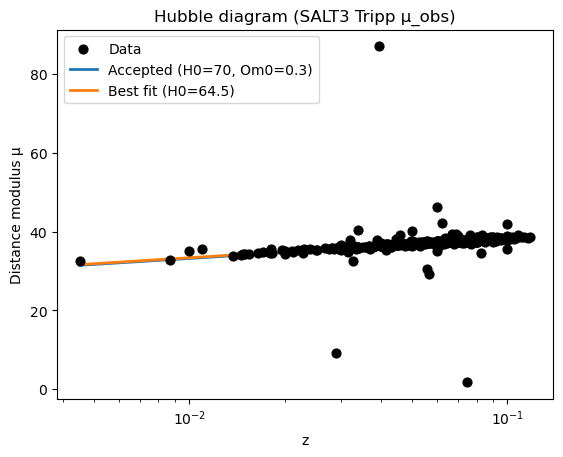

Saved to /Users/david/Code/msc/runs/test3/hubble_residuals.png


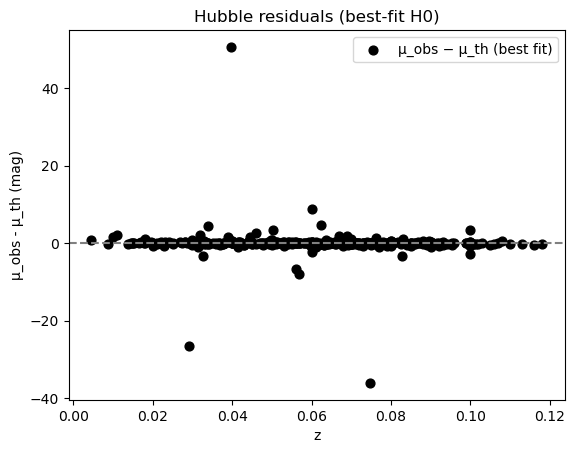

In [ ]:
# Pull out numpy arrays
z_data = dfp["host_redshift"].to_numpy()
mu_obs = dfp["mu_obs"].to_numpy()

Om0 = 0.3  # fixed matter density for all models

def mu_theory(z, H0, Om0=Om0):
    """Distance modulus u(z) for flat ΛCDM."""
    return FlatLambdaCDM(H0=H0, Om0=Om0).distmod(z).value

# Fit H0 
def loss(H0):
    """Sum of squared u residuals for a given H0."""
    return np.sum((mu_obs - mu_theory(z_data, H0)) ** 2)

res = minimize_scalar(loss, bounds=(50, 100), method="bounded")
H0_best = float(res.x)
print(f"Best-fit H0 = {H0_best:.1f} km/s/Mpc")

# Hubble diagram
plt.figure()
plt.xscale("log")

plt.scatter(dfp["host_redshift"], dfp["mu_obs"], label="Data", color="black", s=40, zorder=5)

plt.plot(z_data, mu_theory(z_data, H0=70.0), label="Accepted (H0=70, Om0=0.3)", lw=2)

plt.plot(z_data, mu_theory(z_data, H0_best), label=f"Best fit (H0={H0_best:.1f})", lw=2)

plt.xlabel("z")
plt.ylabel("Distance modulus u")
plt.title("Hubble diagram (SALT3 Tripp u_obs)")
plt.legend()

out_path = run_folder / "hubble_diagram.png"
plt.savefig(out_path, dpi=150)
print(f"Saved to {out_path}")
plt.show()

# Residuals: u_obs − u_th for best-fit.  - brighter,  + dimmer 
mu_th_best = mu_theory(z_data, H0_best)
resid_best = mu_obs - mu_th_best

plt.figure()
plt.axhline(0, color="gray", ls="--")
plt.scatter(dfp["host_redshift"], resid_best, label="u_obs − u_th (best fit)", color="black", s=40)

plt.xlabel("z")
plt.ylabel("μ_obs - u_th (mag)")
plt.title("Hubble residuals (best-fit H0)")
plt.legend()

resid_path = run_folder / "hubble_residuals.png"
plt.savefig(resid_path, dpi=150)
print(f"Saved to {resid_path}")
plt.show()
